# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
!pip install imblearn

In [2]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

## Подготовка данных

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.columns = df.columns.str.lower()

Ознакомимся с данными

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


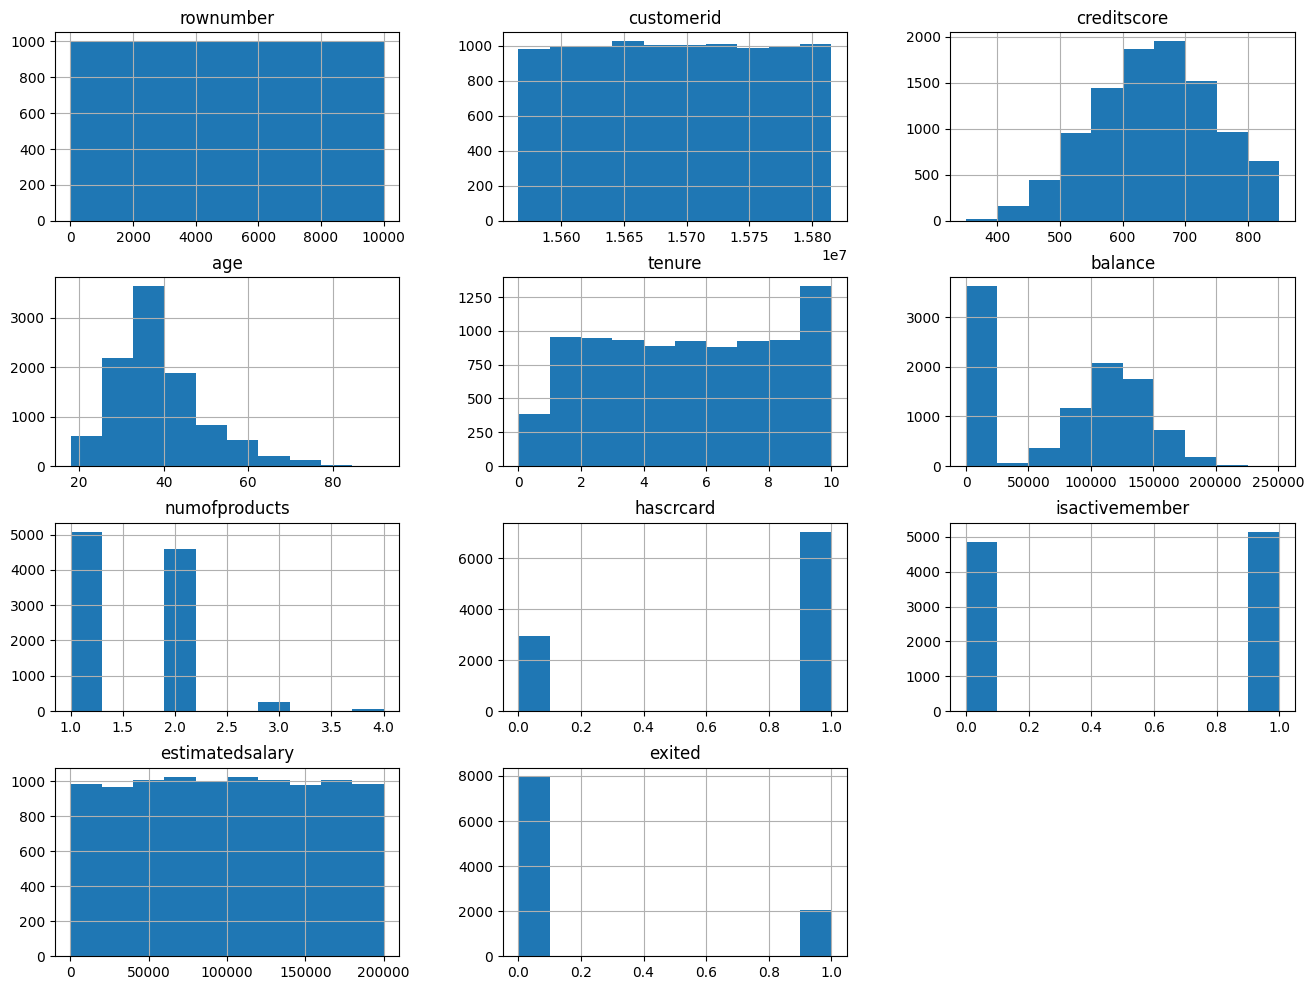

In [6]:
df.hist(figsize = (16, 12));

В столбце `tenure` большое количество пропусков. Посмотрим на распределение параметров там, где они встречаются

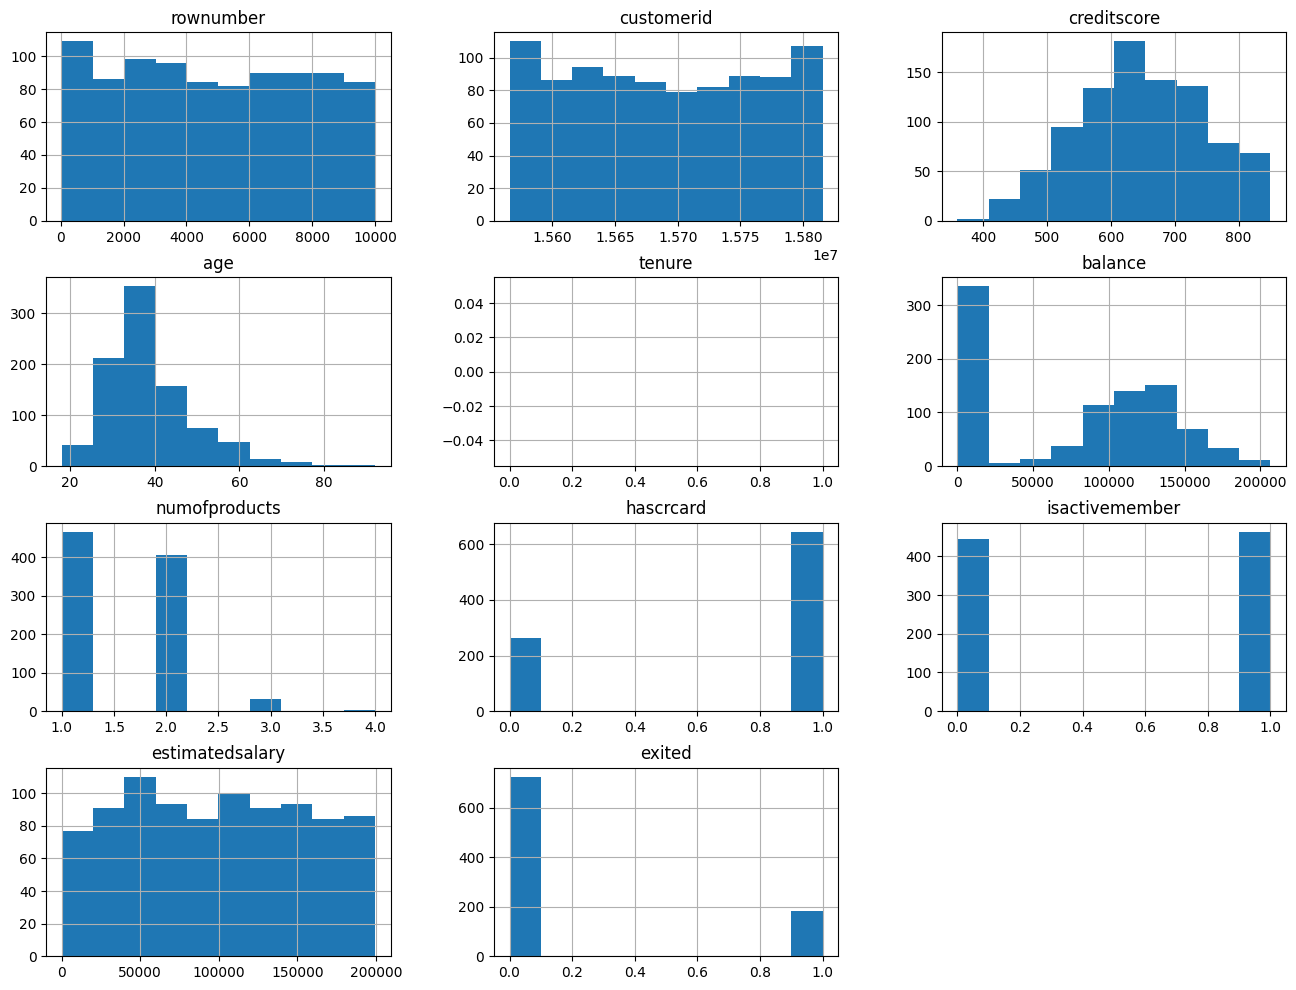

In [7]:
df[df['tenure'].isna()].hist(figsize = (16, 12));

- На гистограммах не видно особых закономерностей в пропущенных данных, по которым их можно было бы восстановить.
- Форма распределения всех признаков в экземплярах с пропусками и без них примерно одинакова.
- Количество данных с пропусками составляет около 10% датасета.

Удалим пропущенные данные.

In [8]:
df = df.dropna()

Имена пользователей, их ID и порядковые номера для анализа не нужны и будут только ухудшать качество моделей, поэтому избавимся от них

In [9]:
df = df.loc[:, 'creditscore':]

Преобразуем категориальные признаки (страна, пол) методом OHE

In [10]:
df = pd.get_dummies(df, drop_first = True)

## Исследование задачи

### Баланс классов

Рассмотрим баланс классов

In [11]:
df['exited'].value_counts(normalize = True)

0    0.796062
1    0.203938
Name: exited, dtype: float64

Дисбаланс классов в соотношении 4:1.

### Разбиение выборки

Выделим целевой признак `exited` разделим данные на стратифицированные обучающую и тестовую выборки и проверим что в получившихся выборках соотношение классов одинаковое.

In [12]:
features = df.drop('exited', axis = 1)
target = df['exited']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, stratify = target, random_state = 42)
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(0    0.796067
 1    0.203933
 Name: exited, dtype: float64,
 0    0.796042
 1    0.203958
 Name: exited, dtype: float64)

Для улучшения качества линейных моделей произведём масштабирование признаков

In [13]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])
display(x_train[numeric].describe())
x_test[numeric].describe()

,creditscore,age,tenure,balance,numofproducts,estimatedsalary
count,7.272000e+03,7.272000e+03,7.272000e+03,7.272000e+03,7.272000e+03,7.272000e+03
mean,-5.481497e-16,-6.155692e-17,9.770940e-17,-6.693094e-17,8.403008e-17,-1.304420e-16
std,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00
min,-3.111186e+00,-1.983304e+00,-1.726848e+00,-1.234838e+00,-9.090866e-01,-1.736629e+00
25%,-6.973763e-01,-6.588203e-01,-1.035691e+00,-1.234838e+00,-9.090866e-01,-8.515604e-01
50%,1.744281e-02,-1.857904e-01,1.045480e-03,3.386257e-01,-9.090866e-01,-5.192677e-03
75%,7.011829e-01,4.764514e-01,6.922030e-01,8.144834e-01,8.183442e-01,8.564137e-01
max,2.068663e+00,4.639115e+00,1.728939e+00,2.791103e+00,4.273206e+00,1.741386e+00


,creditscore,age,tenure,balance,numofproducts,estimatedsalary
count,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000
mean,0.021760,-0.006928,0.001235,-0.034709,0.033925,0.027464
std,0.993711,0.993067,1.001773,1.000254,1.017630,1.010626
min,-3.111186,-1.983304,-1.726848,-1.234838,-0.909087,-1.735263
25%,-0.640398,-0.658820,-0.690112,-1.234838,-0.909087,-0.830302
50%,0.038162,-0.185790,0.001045,0.276129,0.818344,0.041652
75%,0.690823,0.476451,1.037782,0.796712,0.818344,0.889296
max,2.068663,5.017539,1.728939,2.319904,4.273206,1.741008


### Логистическая регрессия

Рассмотрим модель логистичесной регрессии

In [14]:
linear_model = LogisticRegression()
linear_f1 = cross_val_score(linear_model, x_train, y_train, cv=5, scoring='f1')
linear_roc_auc = cross_val_score(linear_model, x_train, y_train, cv=5, scoring='roc_auc')
linear_f1.mean(), linear_roc_auc.mean()

(0.3221811076806378, 0.7678046042891962)

### Дерево решений

Для подбора параметров Decision Tree и Random Forest воспользуемся функцией `GridSearchCV`

In [15]:
scoring = {'f1' : 'f1', 'ROC-AUC' : 'roc_auc'}

In [16]:
%%time

tree_hyperparams = {'max_depth' : [i for i in range(1, 50)]}

tree_search = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state = 42),
    param_grid = tree_hyperparams,
    scoring = scoring,
    cv = 5,
    refit = 'f1',
    return_train_score = True)

tree_search.fit(x_train, y_train)

CPU times: user 13.1 s, sys: 53 ms, total: 13.2 s
Wall time: 13.3 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             refit='f1', return_train_score=True,
             scoring={'ROC-AUC': 'roc_auc', 'f1': 'f1'})

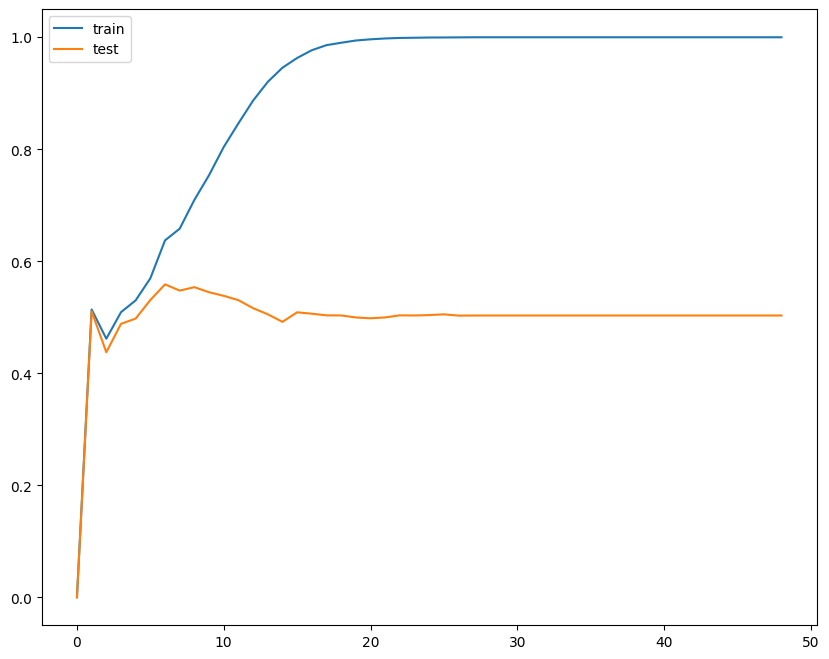

In [17]:
def learning_curve(grid_search, figsize = (10, 8)):
    pd.DataFrame(
        zip(grid_search.cv_results_['mean_train_f1'],
            grid_search.cv_results_['mean_test_f1']),
        columns = ['train', 'test']).plot(figsize = figsize)

def get_final_scores(grid_search):
    print ('Лучшая модель \t', grid_search.best_estimator_)
    print ('f1 \t\t', grid_search.best_score_)
    print ('ROC-AUC \t', grid_search.cv_results_['mean_test_ROC-AUC'][grid_search.best_index_])

learning_curve(tree_search)

Выведем лучшую модель, её f1-меру и ROC-AUC

In [18]:
get_final_scores(tree_search)

Лучшая модель 	 DecisionTreeClassifier(max_depth=7, random_state=42)
f1 		 0.5587542652349649
ROC-AUC 	 0.8313767950054846


### Случайный лес

In [19]:
%%time

forest_hyperparams = {'n_estimators' : [i for i in range(10, 51, 10)], 'max_depth' : [i for i in range(1, 20)]}

forest_search = GridSearchCV(
    estimator = RandomForestClassifier(random_state = 42),
    param_grid = forest_hyperparams,
    scoring = scoring,
    cv = 5,
    refit = 'f1',
    return_train_score = True)

forest_search.fit(x_train, y_train)

CPU times: user 2min 19s, sys: 378 ms, total: 2min 20s
Wall time: 2min 20s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'n_estimators': [10, 20, 30, 40, 50]},
             refit='f1', return_train_score=True,
             scoring={'ROC-AUC': 'roc_auc', 'f1': 'f1'})

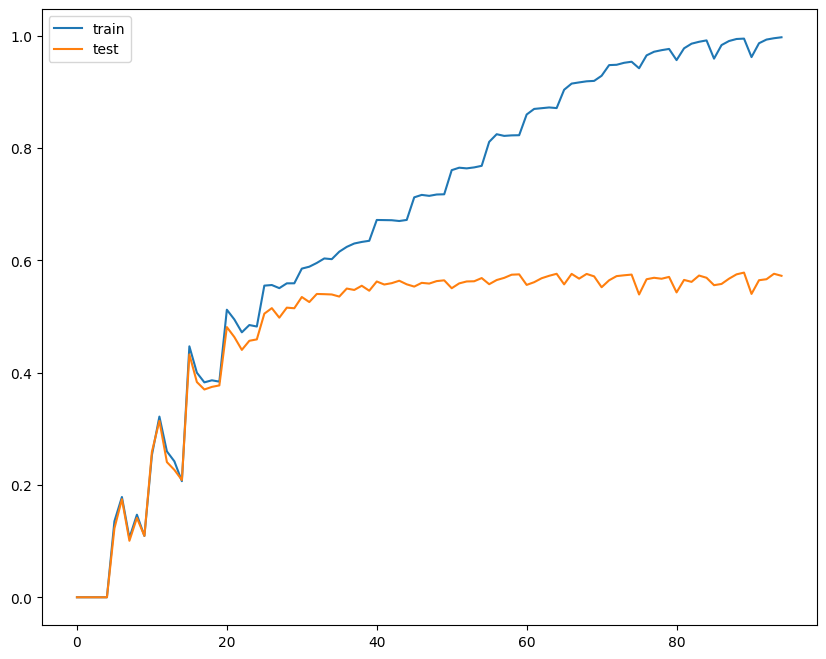

In [20]:
learning_curve(forest_search)

Выведем лучшую модель, её f1-меру и ROC-AUC

In [21]:
get_final_scores(forest_search)

Лучшая модель 	 RandomForestClassifier(max_depth=18, n_estimators=50, random_state=42)
f1 		 0.5783642617163194
ROC-AUC 	 0.8527933173576088


### Вывод

Случайный лес показывает наиболее высокое значение f1-меры из всех изученных моделей (0.58). Дополнительно можно отметить, что дерево решений имеет более высокое значение ROC-AUC (0.83 против 0.82 у случайного леса)

## Борьба с дисбалансом

Для борьбы с дисбалансом рассмотрим три метода:
1. Взвешивание классов
2. Upsampling
3. Downsampling

### Взвешивание классов

#### Логистическая регрессия

In [22]:
balanced_linear_model = LogisticRegression(class_weight = 'balanced')
balanced_linear_f1 = cross_val_score(balanced_linear_model, x_train, y_train, cv=5, scoring='f1')
balanced_linear_roc_auc = cross_val_score(balanced_linear_model, x_train, y_train, cv=5, scoring='roc_auc')
balanced_linear_f1.mean(), balanced_linear_roc_auc.mean()

(0.49804379421437367, 0.7710370018301166)

#### Дерево решений

In [23]:
%%time

balanced_tree_search = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state = 42,
                                      class_weight = 'balanced'),
    param_grid = tree_hyperparams,
    scoring = scoring,
    cv = 5,
    refit = 'f1',
    return_train_score = True)

balanced_tree_search.fit(x_train, y_train)

CPU times: user 13.3 s, sys: 111 ms, total: 13.4 s
Wall time: 13.4 s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             refit='f1', return_train_score=True,
             scoring={'ROC-AUC': 'roc_auc', 'f1': 'f1'})

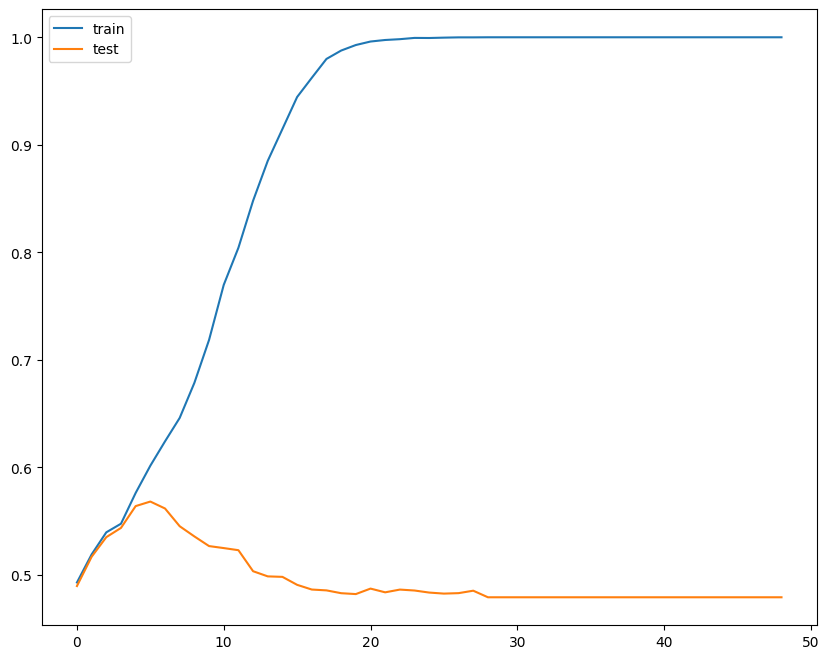

In [24]:
learning_curve(balanced_tree_search)

In [25]:
get_final_scores(balanced_tree_search)

Лучшая модель 	 DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42)
f1 		 0.5682614096535205
ROC-AUC 	 0.8319889262798629


#### Случайный лес

In [26]:
balanced_forest_search = GridSearchCV(
    estimator = RandomForestClassifier(random_state = 42,
                                      class_weight = 'balanced'),
    param_grid = forest_hyperparams,
    scoring = scoring,
    cv = 5,
    refit = 'f1',
    return_train_score = True)

balanced_forest_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'n_estimators': [10, 20, 30, 40, 50]},
             refit='f1', return_train_score=True,
             scoring={'ROC-AUC': 'roc_auc', 'f1': 'f1'})

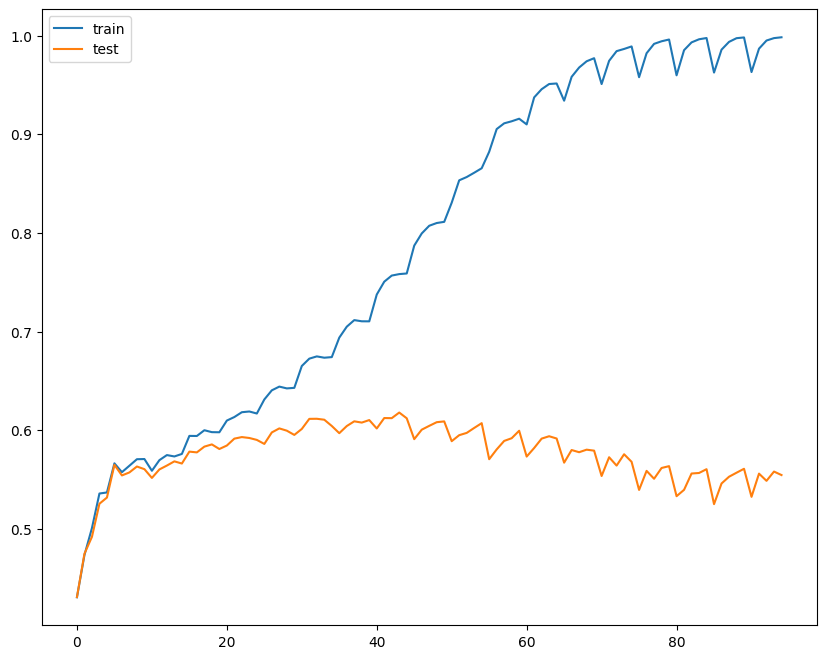

In [27]:
learning_curve(balanced_forest_search)

In [28]:
get_final_scores(balanced_forest_search)

Лучшая модель 	 RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=40,
                       random_state=42)
f1 		 0.6178274430188264
ROC-AUC 	 0.8581534248000793


### Upsampling

Произведём upsampling - продублируем значения так, чтобы количество классов в обучающей выборке сравнялось

In [29]:
def upsample(features, target, repeat, random_state = 42):
    sm = SMOTE(sampling_strategy= 'minority', random_state = random_state)
    x_res, y_res = sm.fit_resample(features, target)

    return x_res, y_res

x_upsampled, y_upsampled = upsample (x_train, y_train, 4)
y_upsampled.value_counts()

0    5789
1    5789
Name: exited, dtype: int64

#### Логистическая регрессия

In [30]:
upsampled_linear_model = LogisticRegression()

upsampled_linear_f1 = cross_val_score(upsampled_linear_model, x_upsampled, y_upsampled, cv=5, scoring='f1')
upsampled_linear_roc_auc = cross_val_score(upsampled_linear_model, x_upsampled, y_upsampled, cv=5, scoring='roc_auc')

upsampled_linear_f1.mean(), upsampled_linear_roc_auc.mean()

(0.7363259685829069, 0.8071387271732897)

#### Дерево решений

In [31]:
%%time

upsampled_tree_search = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state = 42),
    param_grid = tree_hyperparams,
    scoring = scoring,
    cv = 5,
    refit = 'f1',
    return_train_score = True)

upsampled_tree_search.fit(x_upsampled, y_upsampled)

CPU times: user 19.9 s, sys: 110 ms, total: 20.1 s
Wall time: 20 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             refit='f1', return_train_score=True,
             scoring={'ROC-AUC': 'roc_auc', 'f1': 'f1'})

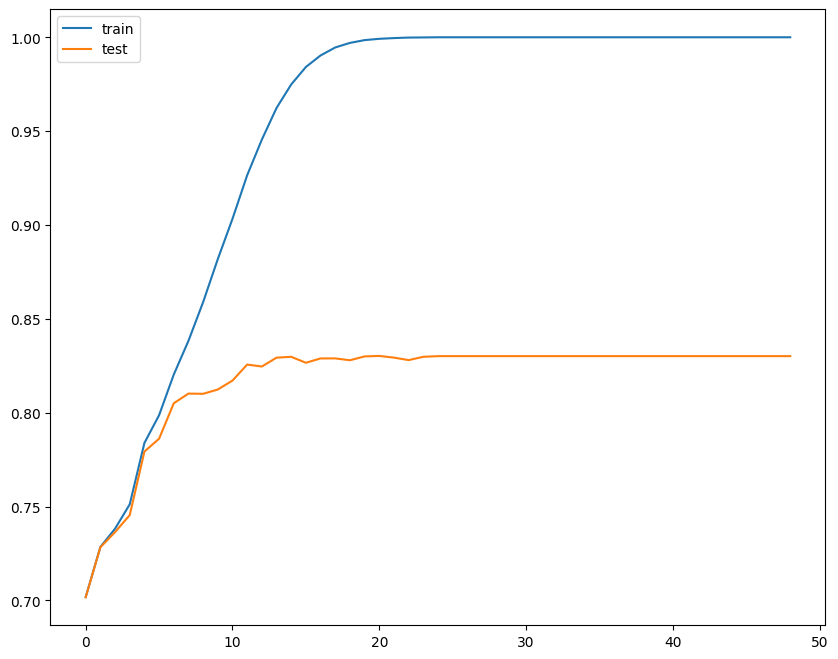

In [32]:
learning_curve(upsampled_tree_search)

In [33]:
get_final_scores(upsampled_tree_search)

Лучшая модель 	 DecisionTreeClassifier(max_depth=21, random_state=42)
f1 		 0.8302243564872811
ROC-AUC 	 0.8306649769600212


#### Случайный лес

In [34]:
%%time

upsampled_forest_search = GridSearchCV(
    estimator = RandomForestClassifier(random_state = 42),
    param_grid = forest_hyperparams,
    scoring = scoring,
    cv = 5,
    refit = 'f1',
    return_train_score = True)

upsampled_forest_search.fit(x_upsampled, y_upsampled)

CPU times: user 3min 40s, sys: 467 ms, total: 3min 41s
Wall time: 3min 41s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'n_estimators': [10, 20, 30, 40, 50]},
             refit='f1', return_train_score=True,
             scoring={'ROC-AUC': 'roc_auc', 'f1': 'f1'})

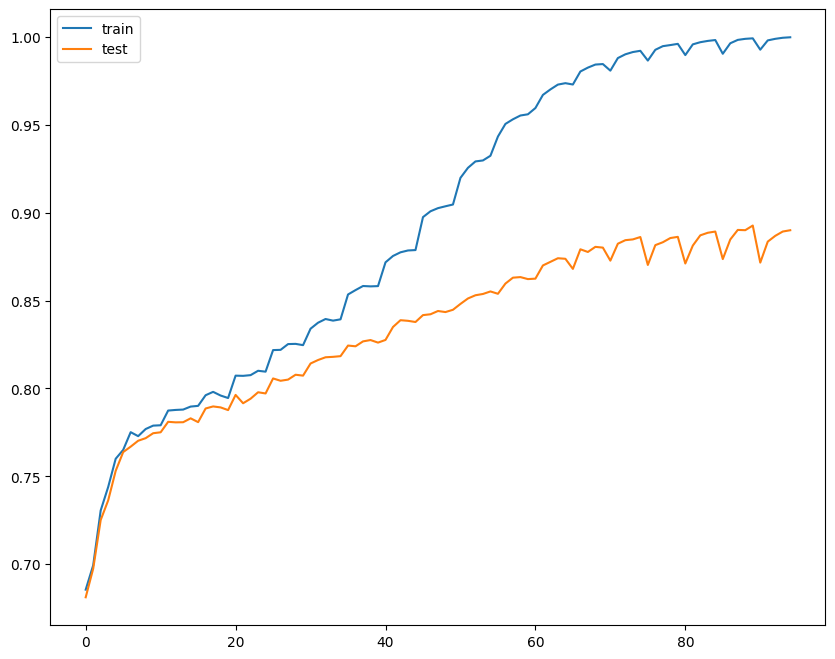

In [35]:
learning_curve(upsampled_forest_search)

In [36]:
get_final_scores(upsampled_forest_search)

Лучшая модель 	 RandomForestClassifier(max_depth=18, n_estimators=50, random_state=42)
f1 		 0.8926882877458849
ROC-AUC 	 0.959220413788827


### Downsampling

In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

x_downsampled, y_downsampled = downsample(x_train, y_train, 0.25)
y_downsampled.value_counts()

1    1483
0    1447
Name: exited, dtype: int64

#### Логистическая регрессия

In [38]:
downsampled_linear_model = LogisticRegression()

downsampled_linear_f1 = cross_val_score(downsampled_linear_model, x_downsampled, y_downsampled, cv=5, scoring='f1')
downsampled_linear_roc_auc = cross_val_score(downsampled_linear_model, x_downsampled, y_downsampled, cv=5, scoring='roc_auc')

downsampled_linear_f1.mean(), downsampled_linear_roc_auc.mean()

(0.7187486157111487, 0.7769041822516944)

#### Дерево решений

In [39]:
%%time

downsampled_tree_search = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state = 42),
    param_grid = tree_hyperparams,
    scoring = scoring,
    cv = 5,
    refit = 'f1',
    return_train_score = True)

downsampled_tree_search.fit(x_downsampled, y_downsampled)

CPU times: user 7.14 s, sys: 96.9 ms, total: 7.24 s
Wall time: 7.17 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             refit='f1', return_train_score=True,
             scoring={'ROC-AUC': 'roc_auc', 'f1': 'f1'})

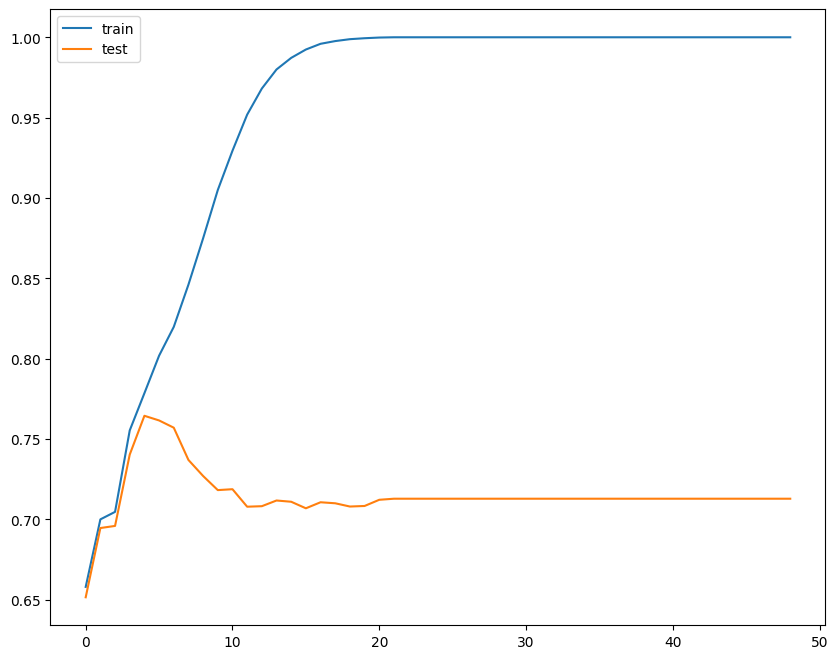

In [40]:
learning_curve(downsampled_tree_search)

In [41]:
get_final_scores(downsampled_tree_search)

Лучшая модель 	 DecisionTreeClassifier(max_depth=5, random_state=42)
f1 		 0.7645044856011461
ROC-AUC 	 0.8376389127491322


#### Случайный лес

In [42]:
%%time

downsampled_forest_search = GridSearchCV(
    estimator = RandomForestClassifier(random_state = 42),
    param_grid = forest_hyperparams,
    scoring = scoring,
    cv = 5,
    refit = 'f1',
    return_train_score = True)

downsampled_forest_search.fit(x_downsampled, y_downsampled)

CPU times: user 1min 19s, sys: 261 ms, total: 1min 20s
Wall time: 1min 20s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'n_estimators': [10, 20, 30, 40, 50]},
             refit='f1', return_train_score=True,
             scoring={'ROC-AUC': 'roc_auc', 'f1': 'f1'})

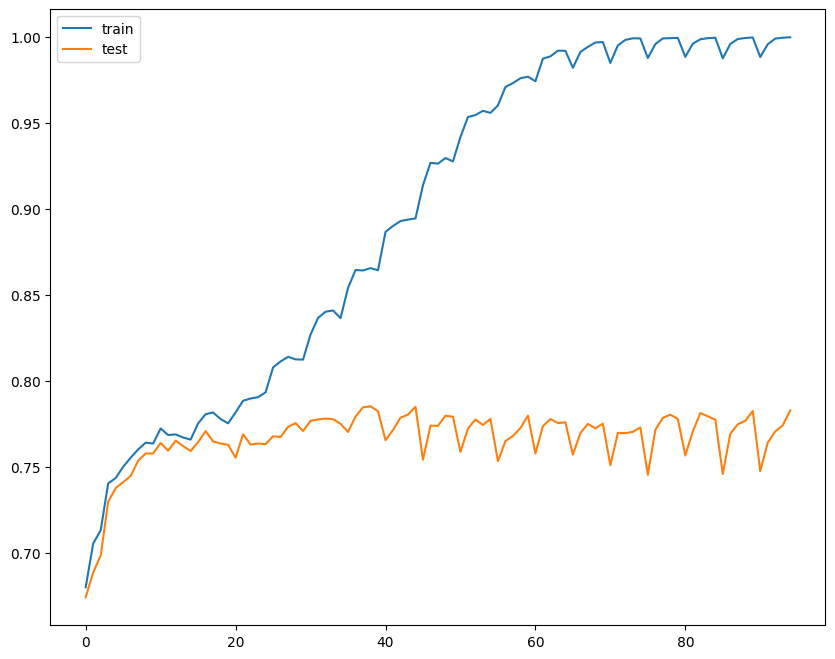

In [43]:
learning_curve(downsampled_forest_search)

In [44]:
get_final_scores(downsampled_forest_search)

Лучшая модель 	 RandomForestClassifier(max_depth=8, n_estimators=40, random_state=42)
f1 		 0.785355735297881
ROC-AUC 	 0.8635954207616301


### Итоги

In [45]:
default = [linear_f1.mean(), tree_search.best_score_, forest_search.best_score_]
balanced = [balanced_linear_f1.mean(), balanced_tree_search.best_score_, balanced_forest_search.best_score_]
upsampled = [upsampled_linear_f1.mean(), upsampled_tree_search.best_score_, upsampled_forest_search.best_score_]
downsampled = [downsampled_linear_f1.mean(), downsampled_tree_search.best_score_, downsampled_forest_search.best_score_]
results = pd.DataFrame(
    [default, balanced, upsampled, downsampled],
    index = ['default', 'balanced', 'upsampled', 'downsampled'],
    columns = ['logistic regression', 'decision tree', 'random forest'])
results

,logistic regression,decision tree,random forest
default,0.322181,0.558754,0.578364
balanced,0.498044,0.568261,0.617827
upsampled,0.736326,0.830224,0.892688
downsampled,0.718749,0.764504,0.785356


Для устранения дисбаланса классов применены три техники - взвешивание классов, upsampling и  downsampling. Наилучшие результаты показывает модель случайного леса при применении техники upsampling.

In [46]:
default = [linear_roc_auc.mean(), tree_search.cv_results_['mean_test_ROC-AUC'][tree_search.best_index_], forest_search.cv_results_['mean_test_ROC-AUC'][forest_search.best_index_]]
balanced = [balanced_linear_roc_auc.mean(), balanced_tree_search.cv_results_['mean_test_ROC-AUC'][balanced_tree_search.best_index_], balanced_forest_search.cv_results_['mean_test_ROC-AUC'][balanced_forest_search.best_index_]]
upsampled = [upsampled_linear_roc_auc.mean(), upsampled_tree_search.cv_results_['mean_test_ROC-AUC'][upsampled_tree_search.best_index_], upsampled_forest_search.cv_results_['mean_test_ROC-AUC'][upsampled_forest_search.best_index_]]
downsampled = [downsampled_linear_roc_auc.mean(), downsampled_tree_search.cv_results_['mean_test_ROC-AUC'][downsampled_tree_search.best_index_], downsampled_forest_search.cv_results_['mean_test_ROC-AUC'][downsampled_forest_search.best_index_]]
results = pd.DataFrame(
    [default, balanced, upsampled, downsampled],
    index = ['default', 'balanced', 'upsampled', 'downsampled'],
    columns = ['logistic regression', 'decision tree', 'random forest'])
results

,logistic regression,decision tree,random forest
default,0.767805,0.831377,0.852793
balanced,0.771037,0.831989,0.858153
upsampled,0.807139,0.830665,0.959220
downsampled,0.776904,0.837639,0.863595


Наиболльшее значение AUC-ROC имеет модель случайного леса, обученная на апсемплированной выборке, однако это значение слишком близко к 1, что может свидетельствовать о переобучении модели. Дерево решений имеет примерно одинаковые значения метрики на всех техниках устранения дисбаланса и даже без них.

## Тестирование модели

Наилучшие результаты показала модель случайного леса, обученная на апсемплированной выборке. Проведём проверку на тестовой выборке

In [47]:
f1_score(y_test, upsampled_forest_search.predict(x_test))

0.578146611341632

f1-мера ниже целевого значения.

Проверим на тестовой выборке модель обученную на да даунсемплированной выборке.

In [48]:
f1_score(y_test, downsampled_forest_search.predict(x_test))

0.5921192758253461


f1-мера незначительно рпевышает целевое значение.

Проверим модель, обученную со взвешиванием классов.

In [49]:
f1_score(y_test, balanced_forest_search.predict(x_test))

0.6096938775510204


**На тестовой выборке наилучшие результаты показывает модель случайного леса со взвешенными классами, со следующими гиперпараметрами:**

In [50]:
balanced_forest_search.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=40,
                       random_state=42)

## Вывод

Изучены данные об оттоке клиентов.

- Проведена предобработка данных
    - Изучено распределение признаков
    - Обнаружены пропуски в признаке `tenure`. Не выявлено закономерноестей, позвоволяющих заполнить пропуски на основании других признаков. Ввиду малого количества пропусков (<10%) пропуски были удалены
    - Удалены данные, не относящиеся к исследованию (номера строк, имена, ID)
- Изучен баланс классов. Дисбаланс составляет 4:1 в пользу отрицательных классов.
- Проведено разбиение выборки на обучающую и тестовую в соотношеннии 4:1. Валидационная выборка не выделялась, т. к. было решено использовать кросс-валидацию
- Проведено масштабирование количественных признаков для улучшения качества линейных моделей.
- Проведено первичное обучение моделей и подбор гиперпараметров без учёта дисбаланса классов. Расчитаны значения целевой метрики f1 и дополнительной - AUC-ROC. Ни одна из моделей не достигла целевого значения метрики f1
    - Логистическая регрессия: f1 = 0.32, AUC-ROC = 0.77
    - Дерево решений (max_depth = 6): f1 = 0.56, AUC-ROC = 0.83
    - Случайный лес (max_depth = 18, n_estimators = 50): f1 = 0.58, AUC-ROC = 0.85
- Опробовано три способа борьбы с дисбалансом:
    - взвешивание классов:
        - Логистическая регрессия: f1 = 0.5, AUC-ROC = 0.77
        - Дерево решений (class_weight = 'balanced', max_depth = 6): f1 = 0.57, AUC-ROC = 0.83
        - Случайный лес (max_depth = 18, n_estimators = 50): f1 = 0.62, AUC-ROC = 0.86
    - upsampling:
        - Логистическая регрессия: f1 = 0.74, AUC-ROC = 0.81
        - Дерево решений (max_depth = 6): f1 = 0.83, AUC-ROC = 0.83
        - Случайный лес (class_weight = 'balanced', max_depth = 9, n_estimators = 40): f1 = 0.89, AUC-ROC = 0.96
    - downsampling:
        - Логистическая регрессия: f1 = 0.72, AUC-ROC = 0.81
        - Дерево решений (max_depth = 5): f1 = 0.76, AUC-ROC = 0.84
        - Случайный лес (max_depth = 8, n_estimators = 40): f1 = 0.79, AUC-ROC = 0.86
- Наиболее высокие резульаты во всех случаях показывает модель случайного леса.
- Проведена проверка моделей случайного леса на тестовой выборке
    - модель, обученная на апсемплированной выборке, показавшая наилучный результат на кросс-валидации (f1 = 0.89) на тестовой выборке имеет f1 = 0.58, что ниже порогового значения
    - модель, обученная на даунсемплированной выборке, на тестовой выборке имеет f1 = 0.59
    - наилучший результат показывает модель со взвешенными классами - f1 = 0.61 на тестовой выборке.